# Consuming from topic "data"
In this section we will create the second consumer.

This consumer will compared between three methods of classification:
Decision tree, Random Forest.

In [217]:
# Import libraries
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score
from pyspark.ml.feature import StandardScaler, IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier

In [218]:
from confluent_kafka import Consumer, KafkaError, KafkaException

# creating the consumer
c = Consumer({'bootstrap.servers': "localhost:9092",
              'group.id': "foo",
              'auto.offset.reset': 'earliest'})

In [219]:
# create function that adds from "data" topic to dictionary
def update_d(d, customer):
    # function to update data dict
    temp = json.loads(customer.decode('utf-8'))
    for key, val in temp.items():
        d[key] = val

In [220]:
# create a function that receives a dictionary and tranforms it to a pyspark df
def dict_to_spark_df(d):
    # get column names
    cols = d['0'] 
    # create pandas df from dictionary
    df = pd.DataFrame.from_dict(d) 
    df = df.T 
    df.columns = cols
    df = df.iloc[1:, :]
    # label encoding the target column "custcat"
    le = preprocessing.LabelEncoder()
    df['price_range'] = le.fit_transform(df['price_range'].values)
    # cast df to integer
    df = df.astype('float')
    # send to pyspark
    sparkDF = spark.createDataFrame(df)
    return (sparkDF, cols[0:-2])

In [221]:
# create a function that prepares the df for the clustering algorithms
def prepare_data(data, cols):
    #assemble acolumn of features for the clustering algorithms
    assemble = VectorAssembler(inputCols=cols, outputCol='features')
    assembled_data = assemble.transform(data)
    # standartize data
    scale = StandardScaler(inputCol='features',outputCol='standardized')
    data_scale = scale.fit(assembled_data)
    data_scale_output = data_scale.transform(assembled_data)
    return(data_scale_output)

In [222]:
# create a function that plots the time calculation and accuracy graphs
def PlotResultsFunc(time1, time2, acc1, acc2, title1, title2):
    x_ax = np.arange(len(time1))
    # Plot accuracy 
    plt.figure(figsize = (12,7))
    plt.plot(x_ax, acc1, label = title1)
    plt.plot(x_ax, acc2, label = title2)
    plt.legend()
    plt.title('Accuracy comparison',fontsize=18)
    plt.xlabel('Consumer Iteration',fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()
    # Plot processing time
    plt.figure(figsize = (12,7))
    plt.plot(x_ax, time1, label = title1)
    plt.plot(x_ax, time2, label = title2)
    plt.legend()
    plt.title('Time comparison',fontsize=18)
    plt.xlabel('Consumer Iteration',fontsize=14)
    plt.ylabel('Time [s]', fontsize=14)
    plt.show()

In [223]:
# create a function for models
def CreateModel(time_lst, acc_lst, labelIndexer, featureIndexer, model_name, labelConverter, trainingData, testData):
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, model_name, labelConverter])
    start_time_lst = time.time()
    model = pipeline.fit(trainingData)
    end_time_lst = time.time()
    time_lst.append(end_time_lst - start_time_lst)
    # Make predictions and select example rows to display.
    predictions = model.transform(testData)
    predictions.select("predictedLabel", "price_range", "features").show(5)
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel",
                                                  predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc_lst.append(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
#     print("Fit Time = " + str(time_lst[-1]))
    return time_lst, acc_lst
                    

In [224]:
# create function to consume and process the data from the topics
def infinite_consumer(c, topics):
    try:
        c.subscribe(topics)
        # create a dictionary where we keep the data
        d = {}
        counter = 0
        #create 2 lists for timing each classification algorithm as they fit the model
        time_RF = []
        time_DT = []
        #create 2 lists for accuracy of each classification algorithm as they fit the model
        acc_RF = []
        acc_DT = []
        while True:
            # consume from topics with time-out of 5 seconds
            messages = c.consume(timeout=5) 
            # read messages from topics
            for msg in messages:
                counter = counter+1
                print(counter)
                # check if no errors or nones
                if msg is None: continue
                if msg.error():
                    if msg.error().code() == KafkaError._PARTITION_EOF:
                        # End of partition event
                        sys.stderr.write('%% %s [%d] reached end at offset %d\n' %(msg.topic(), msg.partition(), msg.offset()))
                    elif msg.error():
                        raise KafkaException(msg.error())
                # if there are no errors we can use the messages for our task
                elif msg.topic() == 'data':
                    # add data logs to our dictionary
                    update_d(d, msg.value())
                    print(next(iter((d.items()))))
                    # send content of dictionary to spark dataframe
                    data, cols = dict_to_spark_df(d)
                    # prepare data for clustering algorithms
                    data = prepare_data(data, cols)                    
                    # Index labels, adding metadata to the label column.
                    # Fit on whole dataset to include all labels in index.
                    labelIndexer = StringIndexer(inputCol="price_range", outputCol="indexedLabel").fit(data)
                    # Set maxCategories so features with > 4 distinct values are treated as continuous.
                    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)      
                    # split to train and test
                    (trainingData, testData) = data.randomSplit([0.7, 0.3])
                    # Convert indexed labels back to original labels.
                    labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                                   labels=labelIndexer.labels)
                    
                    # DECISION TREE
                    dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
                    time_DT, acc_DT = CreateModel(time_DT, acc_DT, labelIndexer, featureIndexer, dt, 
                                                  labelConverter, trainingData, testData)
                    # RANDOM FOREST
                    rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=30)
                    time_RF, acc_RF = CreateModel(time_RF, acc_RF, labelIndexer, featureIndexer, 
                                                  rf, labelConverter, trainingData, testData)  

                    
                    
                    
            if counter==20:
                PlotResultsFunc(time_RF, time_DT, acc_RF, acc_DT,"Random Forest", "Decision Tree")
                counter = 0
    finally:
        # close consumer
        c.close()


1
('0', ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range'])
+--------------+-----------+--------------------+
|predictedLabel|price_range|            features|
+--------------+-----------+--------------------+
|           0.0|        0.0|[509.0,1.0,0.6,1....|
|           1.0|        1.0|[1131.0,1.0,0.5,1...|
|           1.0|        0.0|[1445.0,1.0,0.5,0...|
|           3.0|        3.0|[1821.0,0.0,1.7,0...|
|           0.0|        0.0|[1866.0,0.0,0.5,0...|
+--------------+-----------+--------------------+
only showing top 5 rows

Test Error = 0.36
+--------------+-----------+--------------------+
|predictedLabel|price_range|            features|
+--------------+-----------+--------------------+
|           0.0|        0.0|[509.0,1.0,0.6,1....|
|           1.0|        1.0|[1131.0,1.0,0.5,1...|
|           0.0

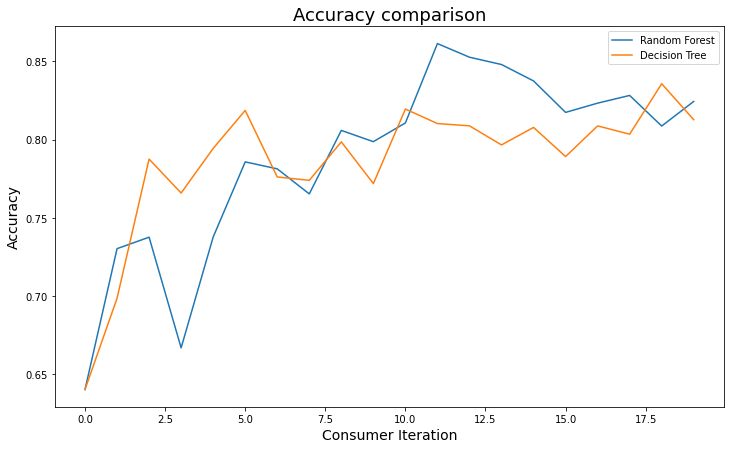

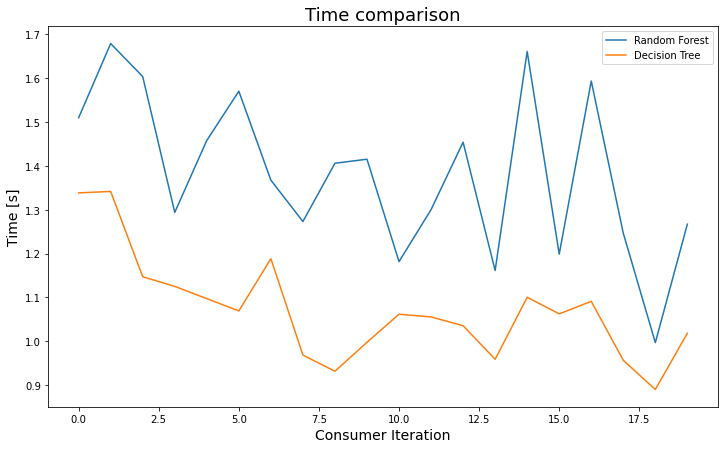

In [ ]:
infinite_consumer(c, ['data'])